In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
plt.style.use('fivethirtyeight')

# Problem 11.4 - Fogler - 5ed

The elementary, irreversible, organic liquid-phase reaction 
\begin{equation}
    A + B \rightarrow C
\end{equation}

is carried out adiabatically in a flow reactor. An equal molar feed in A and B enters at 27C, and the volumetric flow rate is 2 dm3/s and CA0 = 0.1 kmol/m$^3$.

_Additional information_:

Parameter | Value | Parameter | Value
- | - | - | -
HA(273 K) | -20 kcal/mol | CpA | 15 cal/mol/K
HB(273 K) | -15 kcal/mol | CpB | 15 cal/mol/K
HC(273 K) | -41 kcal/mol | CpC | 30 cal/mol/K
k (300 K) | 0.01 dm$^3$/mol/s | E | 10,000 cal/mol

**PFR**
1. Plot and then analyze the conversion and temperature as a function of PFR volume up to where X = 0.85. Describe the trends.
2. What is the maximum inlet temperature one could have so that the boiling point of the liquid (550 K) would not be exceeded even for complete conversion?
3. Plot the heat that must be removed along the reactor ( Q ̇ vs. V) to maintain isothermal operation.
4. Plot and then analyze the conversion and temperature profiles up to a PFR reactor volume of 10 dm3 for the case when the reaction is reversible with KC = 10 m3/kmol at 450 K. Plot the equilibrium conversion profile. How are the trends different than part (a)?

**CSTR**
- What is the CSTR volume necessary to achieve 90% conversion?

# Data

In [3]:
HA_273 = -20000    # Standard enthalpy for A, cal/mol
HB_273 = -15000    # Standard enthalpy for B, cal/mol
HC_273 = -41000    # Standard enthalpy for C, cal/mol

To = 300.15        # Feed temperature, K
vo = 2             # inlet volumetruc flow rate, dm3/s
Cao = 0.1          # Initial concetration for A, mol/dm3

CpA = 15           # heat capacity for A, cal/mol/K
CpB = 15           # heat capacity for B, cal/mol/K
CpC = 30           # heat capacity for C, cal/mol/K

k_300 = 0.01       # kinetic constant at 300 K, dm3/mol/s
Ea = 10000         # Activation energy, cal/mol

Rgas = 1.987       # Universal gas constant, cal/mol/K

Xamax = 0.85

In [4]:
Fao = Cao * vo

In [5]:
Dh = HC_273 - HB_273 - HA_273

print('The reaction heat at 300K is {:.2f} cal/mol'.format(Dh))

The reaction heat at 300K is -6000.00 cal/mol


# PFR
## Part (a)

We need to solve the mole balance and energy balance, simultaneously

The mole balance:

\begin{align}
&\frac{dx}{dV} = -\frac{r_A}{F_{Ao}} \\
&r_A = - k(T) \, C_{Ao}^2 \, \left(1-x\right)^2\\
&k(T) = k(300) \exp\left(\frac{-Ea}{R}\left( \frac{1}{T}-\frac{1}{300}\right)\right)
\end{align}

The energy balance

\begin{equation} 
T = To - \frac{\Delta H\, x}{\sum{\theta_i \, Cp_i} + \Delta Cp \, x}
\end{equation}

In [6]:
def system(x, v):
    t = To - (Dh * x) / (CpA + CpB)
    k = k_300 * np.exp(-Ea/Rgas * (1/t - 1/To))
    
    ra = -k * Cao**2 * (1-x)**2
    
    dv_dx = -Fao / ra
    return dv_dx
    

In [7]:
# initial condition
ICs = [0]            # the initial volume of the reactor is 0

xspan = [0, Xamax]  #  independent variable range

solODE = solve_ivp(system, xspan, ICs, t_eval=np.linspace(0, Xamax))

In [8]:
print('The reactor volume is {:.2f} dm^3'.format(solODE.y[0][-1]))

The reactor volume is 305.10 dm^3


The temperature profile is calculated from the energy balance based on the conversion profile

In [9]:
Temp = To - (Dh * solODE.t) / (CpA + CpB)

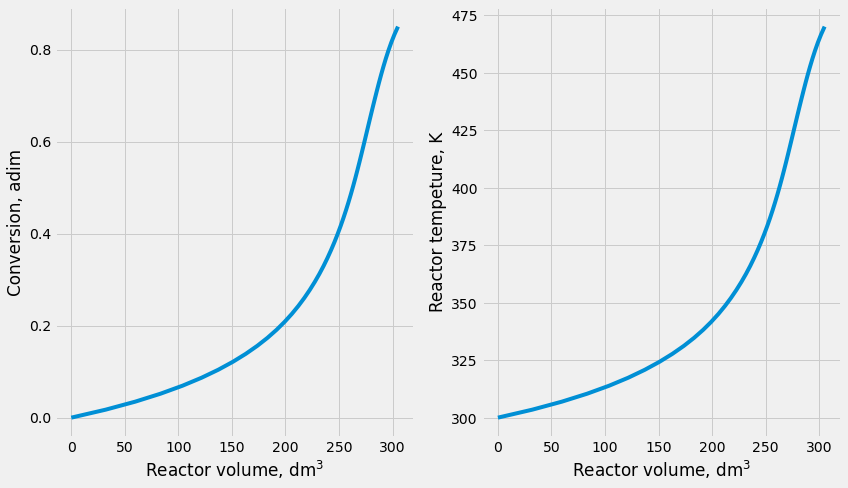

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))

ax1.plot(solODE.y[0], solODE.t)
ax1.set_xlabel(r'Reactor volume, dm$^3$')
ax1.set_ylabel('Conversion, adim')

ax2.plot(solODE.y[0], Temp)
ax2.set_xlabel(r'Reactor volume, dm$^3$')
ax2.set_ylabel('Reactor tempeture, K')

plt.tight_layout()
plt.show()

## Part (b)

This part is direct because can be calculated from the energy balance

\begin{equation}
Tf = To - \frac{\Delta H_r \, X}{CpA + CpB}
\end{equation}

Therefore


\begin{equation}
To = Tf + \frac{\Delta H_r \, X}{CpA + CpB}
\end{equation}

In [11]:
Tf_max = 550
To_max = Tf_max + Dh * Xamax / (CpA + CpB)

print('The maximum inlet temperature is {:.2f} K'.format(To_max))

The maximum inlet temperature is 380.00 K


## Part (c)

The heat that should be removed is the heat of reaction times fractional conversion


In [12]:
heat_to_be_removed = -Dh * solODE.t

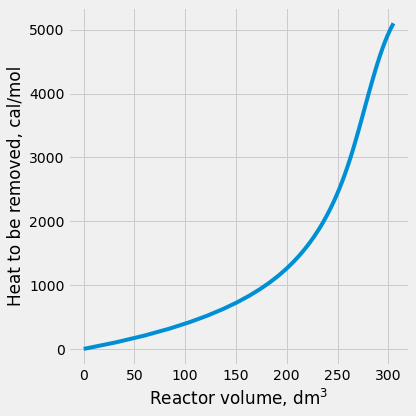

In [13]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(solODE.y[0], heat_to_be_removed)
ax.set_xlabel(r'Reactor volume, dm$^3$')
ax.set_ylabel('Heat to be removed, cal/mol')


plt.tight_layout()
plt.show()

## Part (d)

This part requires to change the kinetic law and include the equilibrium constant into the system

The mole balance:

\begin{align}
&\frac{dx}{dV} = -\frac{r_A}{F_{Ao}} \\
&r_A = - k(T) \left(C_A \,C_B - \frac{C_C}{K_c(T)} \right) \\
&k(T) = k(300) \exp\left(\frac{-Ea}{R}\left( \frac{1}{T}-\frac{1}{300}\right)\right)\\
&Kc(T) = k(450) \exp\left(\frac{-\Delta H}{R}\left( \frac{1}{T}-\frac{1}{450}\right)\right)
\end{align}

with
\begin{align}
&C_A = C_{Ao} \, (1 - x) \\
&C_B = C_{Bo} - C_{Ao} \, x \\
&C_C = C_{Ao} \, x
\end{align}

In [14]:
Vreactor = 10
Kc_450 = 10

In [15]:
def system2(v, x):
    t = To - (Dh * x) / (CpA + CpB)
    k = k_300 * np.exp(-Ea/Rgas * (1/t - 1/To))
    Kc = Kc_450 * np.exp(-Dh/Rgas * (1/t - 1/450))
    
    Ca = Cao * (1-x)
    Cb = Ca
    Cc = Cao * x
    
    ra = -k * (Ca * Cb - Cc/ Kc)
    
    dx_dv = -ra / Fao
    return dx_dv
    

In [16]:
vspan = [0, Vreactor]  #  independent variable range

solODE2 = solve_ivp(system2, vspan, ICs, t_eval=np.linspace(0, Vreactor))

Temp2 = To - (Dh * solODE2.y[0]) / (CpA + CpB)

Let plot both results for the same reactor size (10 dm^3)

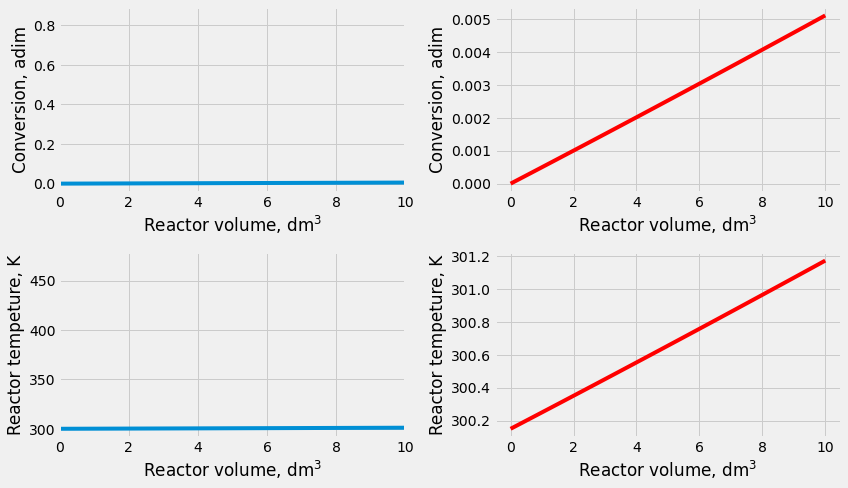

In [17]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 7))

ax1.plot(solODE.y[0], solODE.t)
ax1.set_xlabel(r'Reactor volume, dm$^3$')
ax1.set_ylabel('Conversion, adim')
ax1.set_xlim([0,10])

ax2.plot(solODE2.t, solODE2.y[0], color='red')
ax2.set_xlabel(r'Reactor volume, dm$^3$')
ax2.set_ylabel('Conversion, adim')

ax3.plot(solODE.y[0], Temp)
ax3.set_xlabel(r'Reactor volume, dm$^3$')
ax3.set_ylabel('Reactor tempeture, K')
ax3.set_xlim([0,10])

ax4.plot(solODE2.t, Temp2, color='red')
ax4.set_xlabel(r'Reactor volume, dm$^3$')
ax4.set_ylabel('Reactor tempeture, K')

plt.tight_layout()
plt.show()

In [18]:
print('The final conversion for the reversible scenario is {:.3f}'.format(solODE2.y[0][-1]))

The final conversion for the reversible scenario is 0.005


In [19]:
print('The final temperature for the reversible scenario is {:.2f} K'.format(Temp2[-1]))

The final temperature for the reversible scenario is 301.17 K


At the equilibrium

\begin{equation}
C_A\,C_B = \frac{C_C}{K_C(T)}
\end{equation}

solving

\begin{equation}
C_{A0}\,Kc(T) - \left(2C_{A0}\,Kc(T)+1 \right)\,Xe + C_{A0}\,Kc(T) \,Xe^2= 0
\end{equation}

In [20]:
def x_equilibrium(t):
    kc = Kc_450 * np.exp(-Dh/Rgas * (1/t - 1/450))
    a = Cao * kc
    b = - (2 * Cao * kc + 1)
    c = Cao * kc
    xe = (-b - np.sqrt(b**2 - 4 * a * c))/(2*a)
    return xe

In [21]:
Xe = x_equilibrium(Temp2)

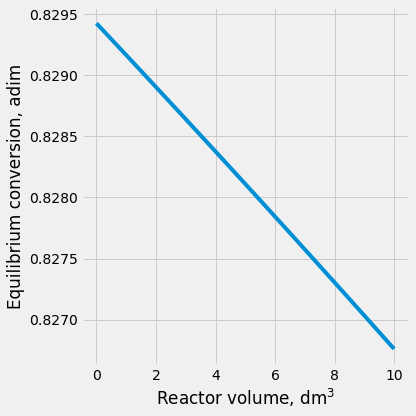

In [22]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(solODE2.t, Xe)
ax.set_xlabel(r'Reactor volume, dm$^3$')
ax.set_ylabel('Equilibrium conversion, adim')

plt.tight_layout()
plt.show()

# CSTR

In [23]:
def system_cstr(x):
    t = To - (Dh * x) / (CpA + CpB)
    k = k_300 * np.exp(-Ea/Rgas * (1/t - 1/To))
    
    ra = -k * Cao**2 * (1-x)**2
    
    v = (Fao * x ) / -ra
    return v

In [24]:
Volume_CSTR = system_cstr(0.9)

In [25]:
print('The required volume for CSTR is {:.2f} dm^3'.format(Volume_CSTR))

The required volume for CSTR is 335.27 dm^3
